# Interpretation of Logistic Regression

In [55]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [56]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import seaborn as sns

#### Let us begin from where we left off in the last workbook. Loading the tree data and applying the same data wrangling I did in my last file.

#### Get the data ready for fitting a logistic regression by dropping missing values and adding a constant for the intercept. 

In [57]:
# Load tree data
df = pd.read_csv('data/clean_tree_data.csv')
# the dataset is much bigger than we need, sampling from it
data_n = 2000
df = df.sample(data_n, random_state=31415)

# taller than 10m is a positive outcome otherwise negative
df['is_tall'] = pd.Series(df['tree_height_fixed'] > 10).astype(int)
Y = df['is_tall']

# streamline tree treatment for efficiency
df['growing_freely'] = pd.Series(
    df['tree_treatment'] == 'Boom vrij uitgroeiend'
).astype(int)

# Create design matrix 
X = pd.DataFrame({
    'diameter': df['diameter'],
    'age': df['age'],
    'growing_freely': df['growing_freely'],
})

categorical_vars = ['species_group']

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    X = pd.concat([X, dummies], axis=1)

X_with_intercept = sm.add_constant(X)
X_with_intercept.dropna(inplace=True)


#### i) The `Homogeneous Probability` model:

#### Fit a logistic regression model with just an intercept, no other covariates. Plot the empirical posterior distribution of the baseline coefficients: a) on the log-odds scale; b) on the odds scale; c) on the probability scale. Interpret this result. 

In [58]:
# Fit the model 
X_just_intercept = X_with_intercept[['const']]
homogeneous_model = sm.Logit(Y, X_just_intercept).fit()

Optimization terminated successfully.
         Current function value: 0.625734
         Iterations 4


In [59]:
# Get summary results
homogeneous_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1999
Method:                           MLE   Df Model:                            0
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:               3.267e-11
Time:                        14:12:05   Log-Likelihood:                -1251.5
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7607      0.048     15.849      0.000       0.667       0.855
==============================================================================
"""

In [60]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = homogeneous_model.params
beta_cov = homogeneous_model.cov_params()

In [61]:
# Number of simulations
n_sim = 1000

# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_sim)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

In [62]:
print(simulated_base)

[[0.74718924 2.11105798 0.67856594]
 [0.65160907 1.91862556 0.65737297]
 [0.70924406 2.03245426 0.6702341 ]
 ...
 [0.76295214 2.14459803 0.68199433]
 [0.70658969 2.02706654 0.66964717]
 [0.79236109 2.20860499 0.68833808]]


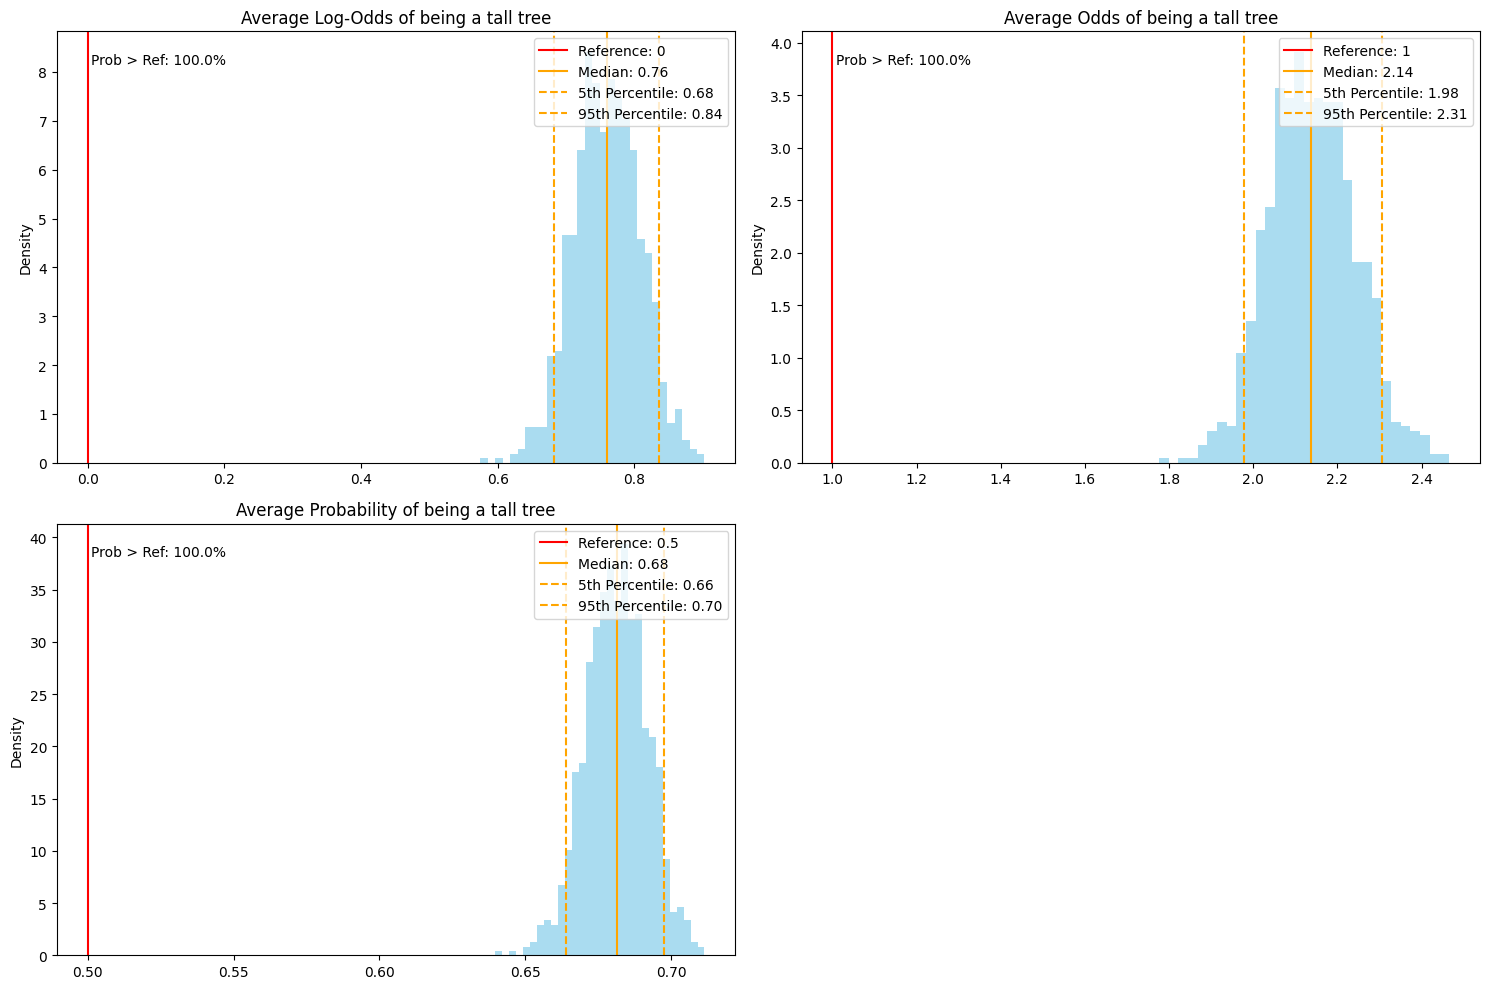

In [63]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of being a tall tree')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Answer: 

These 3 values represent the same thing, the chance that a tree is tall or not. The main difference is the range of values that each can take: log-odds can go from -infinity to +infinity, odds from 0 to +infinity and probability from 0 to 1.

The log-odds represents the value of our coefficient. A positive coefficient indicates that a tree is more likely to be tall than not. It's more difficult to interpret the log-odds, so we convert it to probabilities and odds.

The odds represent the ratio of success to failure, how many tall trees we should see for each small tree, in this case around 2 tall trees for each small tree seem like the plausible true odds of a tree being tall in Amsterdam. 

Probabilities: for any given tree in Amsterdam, the true probability of that tree being "tall" is most likely to be around 0.66, with a credibility interval at 90% of 0.66 to 0.70, so we can plausibly say that the probability of a tree being tall has a 90% chance of sitting between 0.66 and 0.70. Higher and lower values than this probability are less plausible.

#### ii) The `Heterogeneous Probability` model with one binary covariate: 

#### a) Let us build on the previous model. Firstly calculate the AIC (Akaike Information Criteria) of this homogeneous probability model - keep stock of this number, as we will use it to compare models in a few beats.

In [64]:
...

Ellipsis

#### b) Now let us add some complexity to our model. We want to be able to model the fact that individuals have different propensity of voting for Trump based on some of their characteristics. Much has been made of Trump's appeal to non-college educated voters. Let us introduce the dummy `College_Degree` as a covariate, fit the model and plot posterior distribution of the coefficients, on the `odds` scale.

In [65]:
# Fit the model with college education
...

In [66]:
# Get summary results
...

In [67]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
...

In [68]:
# Simulate values of each regression coefficient from the posterior distirbution 
...

In [69]:
# Derive odds from log-odds coefficients 
...

In [70]:
# Calculate statistics for each coefficient
...

# Plot names 
...

# Plot histograms of each coefficient
...

#### c) Interpret the coefficients.

#### Answer: 

...

#### d) Get the AIC of this model, and comment on its value compared to the previous model. 

In [71]:
...

Ellipsis

#### Answer: 

...

#### ii) The `Heterogeneous Probability` model with multiple covariates and interactions: 

#### a) Fit a logit model with education, sex, age, white-ethnicity, and and interaction between education and ethnicity 

(Tip: center and divide age by 10, so it is interpretable as a `10 year increase over the average age` as opposed to a `1 year increase over 0 years` for a 1-unit change)

In [72]:
X_with_intercept['Age'] = (X_with_intercept['Age']- ...)/...

KeyError: 'Age'

In [ ]:
X_with_intercept['NonWhite_College_Interaction'] = X['Ethnicity_NonWhite'] * X['College_Degree']

In [ ]:
# Fit the model with college education
...

# Get summary results
...

Optimization terminated successfully.
         Current function value: 0.641716
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6624
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                 0.05120
Time:                        16:53:20   Log-Likelihood:                -4254.6
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                 5.171e-97
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2841      0.052      5.477      0.000

#### b) Simulate the empirical posterior of each coefficient, and plot the histogram of each respective coefficient on the odds-scale:

In [ ]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
...

In [ ]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
...
# Simulate beta coefficients
...

In [ ]:
# Derive odds from log-odds coefficients 
...

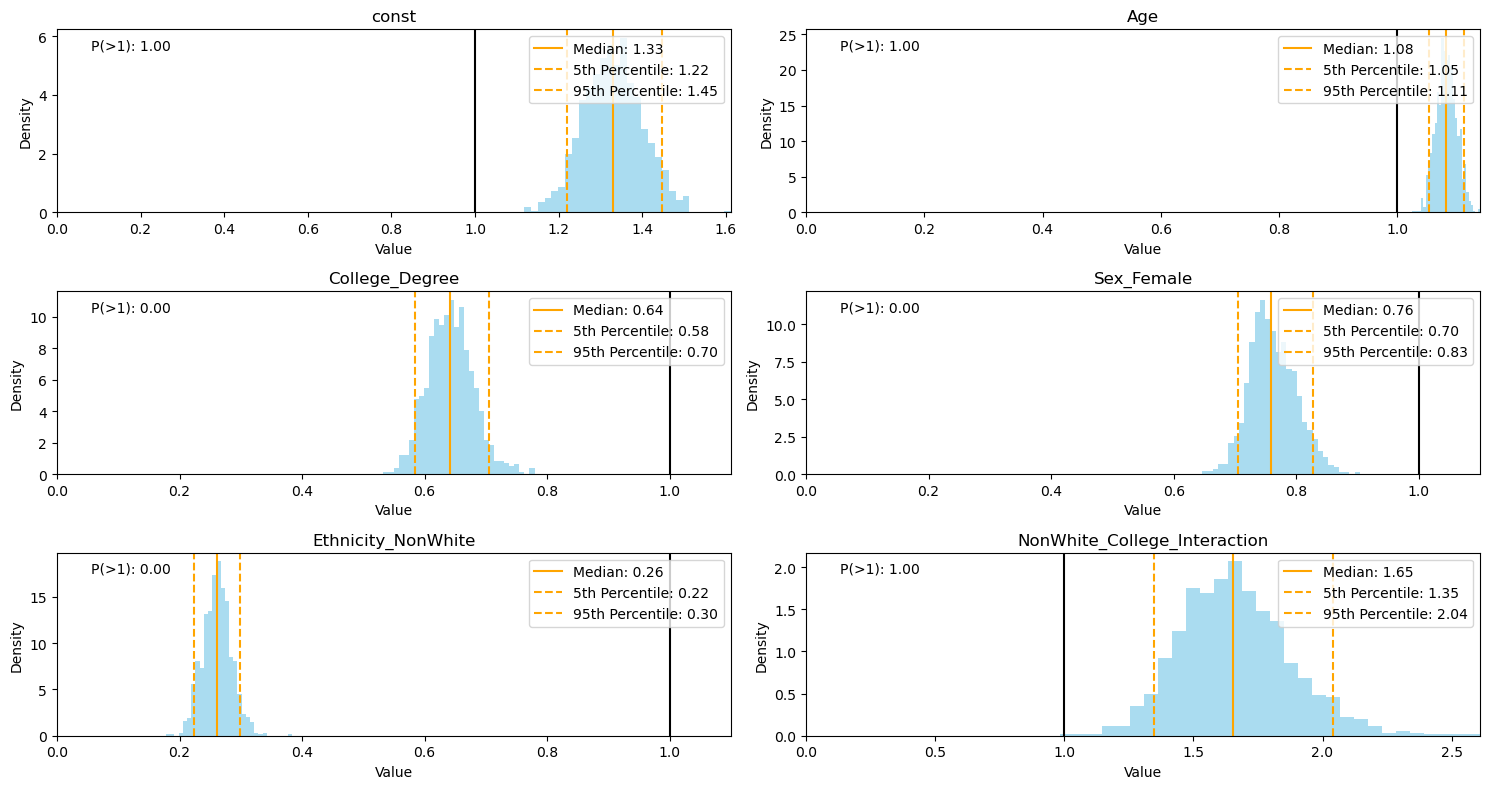

In [ ]:
# Calculate statistics for each coefficient
...
# Plot names 
...
# Plot histograms of each coefficient
...

#### d) Interpret every coefficient in the model. Pay attention to `statistical significance`, and be clear about what the baseline profile over which the effects are calculated is.

#### Answer: 

...


In [ ]:
# Finally, let's get the AIC of the model just to compare with what we did before. 
# Is the added complexity justified ? 
...

Ellipsis

## A final note: 

I suspect you will emerge out of this workshop thinking that odds and odds ratios are, at the very least, `tricky`. I agree with you ! Remember you always have the option of using predicted values for your inference, and calculating Relative Risk and Risk Differences between profiles of interests and reference profiles. We will explore this more in the future workshops. 